# 1. Library

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras import models
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix

# 2. Mount the Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Read the dataframe

In [ ]:
helleborus_df_train = pd.read_csv('/content/drive/My Drive/MasterProject/helleborusname_train.xlsx',dtype=str)
helleborus_df_validation = pd.read_csv('/content/drive/My Drive/MasterProject/helleborusname_validation.xlsx',dtype=str)

# Labels

In [ ]:
labels_helleborus = helleborus_df_train['Class_name'].unique()
len(labels_helleborus)

7

In [ ]:
helleborusname_train = glob('/content/drive/My Drive/MasterProject/split_data/Helleborus/train/*/*.*')
len(helleborusname_train)

129

In [ ]:
labels_helleborus_v = helleborus_df_validation['Class_name'].unique()
len(labels_helleborus_v)

7

# 8. Data augmentation Genus

In [ ]:
image_size = 224
batch_size = 10
n_epochs = 20

In [ ]:
train_datagen_helleborus = ImageDataGenerator(rescale = 1.0/255.,                                            
                                            horizontal_flip = True,                                            
                                            zoom_range=0.1,                                            
                                            rotation_range=15,
                                            fill_mode="constant",
                                            cval=0)
                                   

train_generator_helleborus = train_datagen_helleborus.flow_from_dataframe(dataframe=helleborus_df_train,
                                                    directory=None,
                                                    x_col="File_path",
                                                    y_col="Class_name",
                                                    shuffle = True,
                                                    batch_size=batch_size,
                                                    target_size=(image_size,image_size),
                                                    class_mode='categorical')
validation_datagen_helleborus = ImageDataGenerator(rescale = 1.0/255.)

validation_generator_helleborus = validation_datagen_helleborus.flow_from_dataframe(dataframe=helleborus_df_validation,
                                                         directory=None,
                                                         x_col="File_path",
                                                         y_col="Class_name",
                                                         shuffle = False, 
                                                         batch_size=batch_size,
                                                         target_size=(image_size,image_size), 
                                                         class_mode='categorical')

Found 129 validated image filenames belonging to 7 classes.
Found 20 validated image filenames belonging to 7 classes.


# 9. Download the pretrained algorithms from TensorFlow.

In [ ]:
pretrained_model1 = tf.keras.applications.EfficientNetB7(input_shape=(image_size,image_size,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
pretrained_model1.trainable = False
model_helleborus_EfficientNetB7 = models.Sequential()
model_helleborus_EfficientNetB7.add(pretrained_model1)
model_helleborus_EfficientNetB7.add(Flatten())
model_helleborus_EfficientNetB7.add(Dense(units=512, activation='relu'))
model_helleborus_EfficientNetB7.add(Dropout(0.5))
model_helleborus_EfficientNetB7.add(BatchNormalization())
model_helleborus_EfficientNetB7.add(Dense(units=256, activation='relu'))
model_helleborus_EfficientNetB7.add(Dropout(0.5))
model_helleborus_EfficientNetB7.add(BatchNormalization())
model_helleborus_EfficientNetB7.add(Dense(len(labels_helleborus), activation='softmax'))

258088960/258076736 [==============================] - 2s 0us/step


# Read the table for saving the result in it.

In [ ]:
filepath_metrics = Path('/content/drive/My Drive/MasterProject/metrics.xlsx')
df_metrics = pd.read_csv(filepath_metrics,dtype=str)

# 10. Compile the Model

In [ ]:
helleborus_algorithms_EfficientNetB7 = {'EfficientNetB7 model for Helleborus': model_helleborus_EfficientNetB7}

In [ ]:
def algorithms_helleborus(name,model): 
  global df_metrics 

  model.compile(loss='categorical_crossentropy', 
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])
  
  his_name = model.fit(train_generator_helleborus,
              epochs=n_epochs,
              steps_per_epoch=len(helleborusname_train)/batch_size,
              validation_data=validation_generator_helleborus
              )
  
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax = ax.ravel()
  
  for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(his_name.history[met])
    ax[i].plot(his_name.history['val_' + met])
    ax[i].set_title('Training and validation {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['training', 'validation'])

# For every epoch, append losses to dataframe 
  df_metrics.loc[len(df_metrics.index)] = [name, 
              round((np.amax(his_name.history['accuracy'])*100),2),
              round((np.amax(his_name.history['top_k_categorical_accuracy'])*100),2),
              round((np.amax(his_name.history['val_accuracy'])*100),2),
              round((np.amax(his_name.history['val_top_k_categorical_accuracy'])*100),2),
              round(np.amin(his_name.history['loss']),2),
              round(np.amin(his_name.history['val_loss']),2)]     

  return model

# Run, Save the Models and plot the Result

Epoch 1/20
12/12 [==============================] - 101s 6s/step - loss: 2.6340 - accuracy: 0.1705 - top_k_categorical_accuracy: 0.6977 - val_loss: 2.1604 - val_accuracy: 0.1500 - val_top_k_categorical_accuracy: 0.7500
Epoch 2/20
12/12 [==============================] - 63s 5s/step - loss: 2.5666 - accuracy: 0.1783 - top_k_categorical_accuracy: 0.7054 - val_loss: 2.1775 - val_accuracy: 0.1500 - val_top_k_categorical_accuracy: 0.7500
Epoch 3/20
12/12 [==============================] - 65s 5s/step - loss: 2.4358 - accuracy: 0.1860 - top_k_categorical_accuracy: 0.6977 - val_loss: 2.1098 - val_accuracy: 0.1500 - val_top_k_categorical_accuracy: 0.7500
Epoch 4/20
12/12 [==============================] - 65s 5s/step - loss: 2.2632 - accuracy: 0.1628 - top_k_categorical_accuracy: 0.7907 - val_loss: 2.0219 - val_accuracy: 0.1500 - val_top_k_categorical_accuracy: 0.7500
Epoch 5/20
12/12 [==============================] - 68s 5s/step - loss: 2.6528 - accuracy: 0.1783 - top_k_categorical_accuracy:

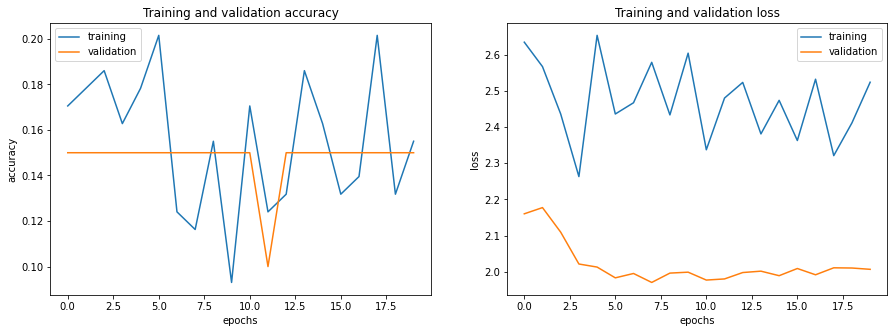

In [ ]:
for key, value in helleborus_algorithms_EfficientNetB7.items():
  model_cultivar = algorithms_helleborus(key,value)
  model_cultivar.save('/content/drive/My Drive/MasterProject/model/' + key + '.h5')

In [ ]:
print(df_metrics)

                          Name of a Model Training Accuracy, %  \
0            DenseNet201 model for Dahlia                21.44   
1               Xception model for Dahlia                28.75   
2      InceptionResNetV2 model for Dahlia                15.94   
3         EfficientNetB7 model for Dahlia                 2.56   
4        DenseNet201 model for Helleborus                 84.5   
5           Xception model for Helleborus                 84.5   
6  InceptionResNetV2 model for Helleborus                65.12   
7     EfficientNetB7 model for Helleborus                20.16   

  Top 5 Training accuracy, % Validation accuracy, %  \
0                      56.93                  51.18   
1                      66.41                  52.94   
2                      50.09                  31.76   
3                      11.01                   2.94   
4                      100.0                   95.0   
5                      100.0                  100.0   
6                   

In [ ]:
filepath_metrics = Path('/content/drive/My Drive/MasterProject/metrics.xlsx')
df_metrics.to_csv(filepath_metrics,index=False)

# Confusion Matrix

In [ ]:
Y_pred = model_helleborus_EfficientNetB7.predict_generator(validation_generator_helleborus, validation_generator_helleborus.samples // validation_generator_helleborus.batch_size + 5)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator_helleborus.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Confusion Matrix
[[0 0 0 0 2 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 3 0 0]]


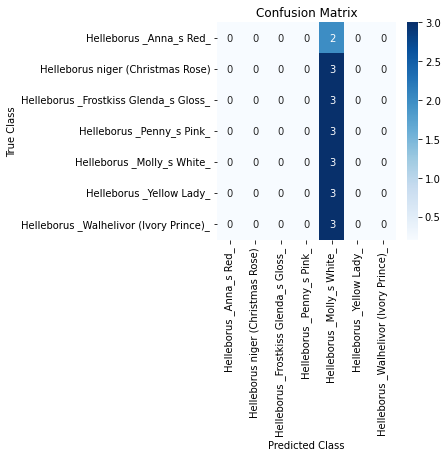

In [ ]:
cm = confusion_matrix(validation_generator_helleborus.classes, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm,xticklabels=labels_helleborus, yticklabels=labels_helleborus, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report

In [ ]:
target_names = list(train_generator_helleborus.class_indices.keys()) 
print(classification_report(validation_generator_helleborus.classes, y_pred, target_names=target_names))

                                        precision    recall  f1-score   support

               Helleborus _Anna_s Red_       0.00      0.00      0.00         2
 Helleborus _Frostkiss Glenda_s Gloss_       0.00      0.00      0.00         3
            Helleborus _Molly_s White_       0.00      0.00      0.00         3
             Helleborus _Penny_s Pink_       0.00      0.00      0.00         3
Helleborus _Walhelivor (Ivory Prince)_       0.15      1.00      0.26         3
              Helleborus _Yellow Lady_       0.00      0.00      0.00         3
     Helleborus niger (Christmas Rose)       0.00      0.00      0.00         3

                              accuracy                           0.15        20
                             macro avg       0.02      0.14      0.04        20
                          weighted avg       0.02      0.15      0.04        20



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction on test dataset

Load the image

In [ ]:
image_path = "/content/drive/My Drive/MasterProject/test/Helleborus/Helleborus _Penny_s Pink_/hellebore-pennys-pink.jpg"
#image_path = "/content/drive/My Drive/MasterProject/test/Dahlia/Dahlia _Alauna Clair-obscur_/Dahlia 'Alauna Clair-obscur'.jpg"
#img_path = "/content/drive/My Drive/MasterProject/test/Dahlia/Dahlia _American Dawn_/dahlia-american-dawn-2.jpg"

In [ ]:
test_images = ["/content/drive/My Drive/MasterProject/test/Dahlia/Dahlia _Alauna Clair-obscur_/Dahlia 'Alauna Clair-obscur'.jpg",
               "/content/drive/My Drive/MasterProject/test/Helleborus/Helleborus _Penny_s Pink_/hellebore-pennys-pink.jpg",
               "/content/drive/My Drive/MasterProject/test/Dahlia/Dahlia _American Dawn_/dahlia-american-dawn-2.jpg"
               ]

Create the function for coding the image

In [ ]:
def load_image(img_path, show=True):
  global name
  name = img_path.split("/")[-2]
  print("The true name is ",name)

  img = image.load_img(img_path, target_size=(image_size, image_size))
  img_tensor = image.img_to_array(img)                    # (height, width, channels)
  img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
  img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

  if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

  return img_tensor

load the table for saving the result

In [ ]:
filepath_result = Path('/content/drive/My Drive/MasterProject/result.xlsx')
df_result = pd.read_csv(filepath_result)

The true name is  Helleborus _Penny_s Pink_


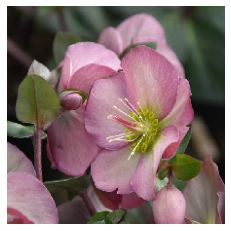

EfficientNetB7 model for Helleborus
Helleborus _Molly_s White_ 23.45 %
Helleborus _Yellow Lady_ 22.0 %
Helleborus _Walhelivor (Ivory Prince)_ 12.11 %
Helleborus niger (Christmas Rose) 11.96 %
Helleborus _Anna_s Red_ 11.62 %
It is  Helleborus _Molly_s White_ with accuracy  23.45 % for EfficientNetB7 model for Helleborus


In [ ]:
# LAST prediction for set of images and set of models for cultivar name
new_image = load_image(image_path)

for key, value in helleborus_algorithms_EfficientNetB7.items():
  print(key)

# check prediction
  validation_generator_helleborus.reset()
  pred = model_helleborus_EfficientNetB7.predict(new_image)
  predictions = np.argmax(pred, axis=1)

  result_dahlia = {labels_helleborus[i]: pred[0][i] for i in range(len(labels_helleborus))}
  sort_result_dahlia = sorted(result_dahlia.items(), key=lambda x: x[1], reverse=True)
  for i in sort_result_dahlia[:5]:
    print(i[0], round((i[1]*100),2), "%")
    df_result.loc[len(df_result.index)] = [key,
                                         name,
                                         i[0],
                                         round((i[1]*100),2)]

print("It is ",labels_helleborus[predictions[0]], "with accuracy ", round((np.amax(pred)*100),2), "% for " + key)

In [ ]:
df_result

,Model,True Name,Name of a Plant,%
0,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _Alauna Clair-obscur_,75.11
1,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _Destiny_s Teachers_,15.17
2,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _Melody Harmony_,7.54
3,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _My Love_,1.62
4,DenseNet201 model for Dahlia,Dahlia _Alauna Clair-obscur_,"Dahlia _Honka Dark_ (Honka Black, Dahlia _Verr...",0.43
5,Xception model for Dahlia,Dahlia _Alauna Clair-obscur_,"Dahlia _Honka Dark_ (Honka Black, Dahlia _Verr...",34.49
6,Xception model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _Melody Harmony_,22.60
7,Xception model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _My Love_,18.04
8,Xception model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _Alauna Clair-obscur_,12.91
9,Xception model for Dahlia,Dahlia _Alauna Clair-obscur_,Dahlia _Destiny_s Teachers_,9.63


In [ ]:
filepath_result = Path('/content/drive/My Drive/MasterProject/result.xlsx')
df_result.to_csv(filepath_result,index=False)

# Check the train and validation images after generator

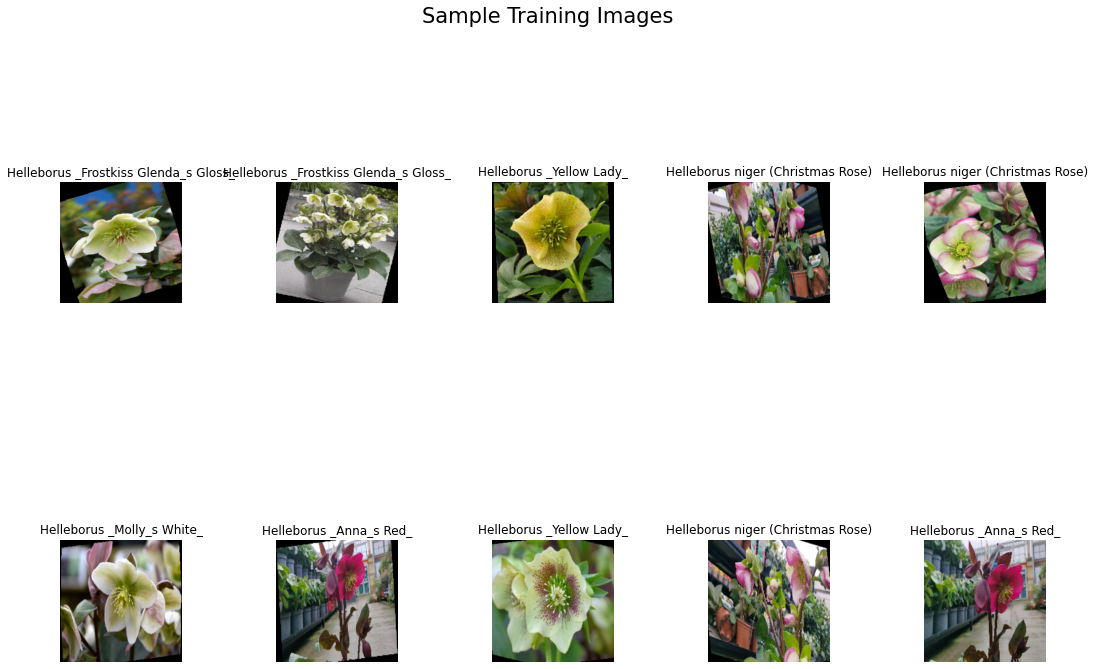

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels_helleborus[np.argmax(train_generator_helleborus[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator_helleborus[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

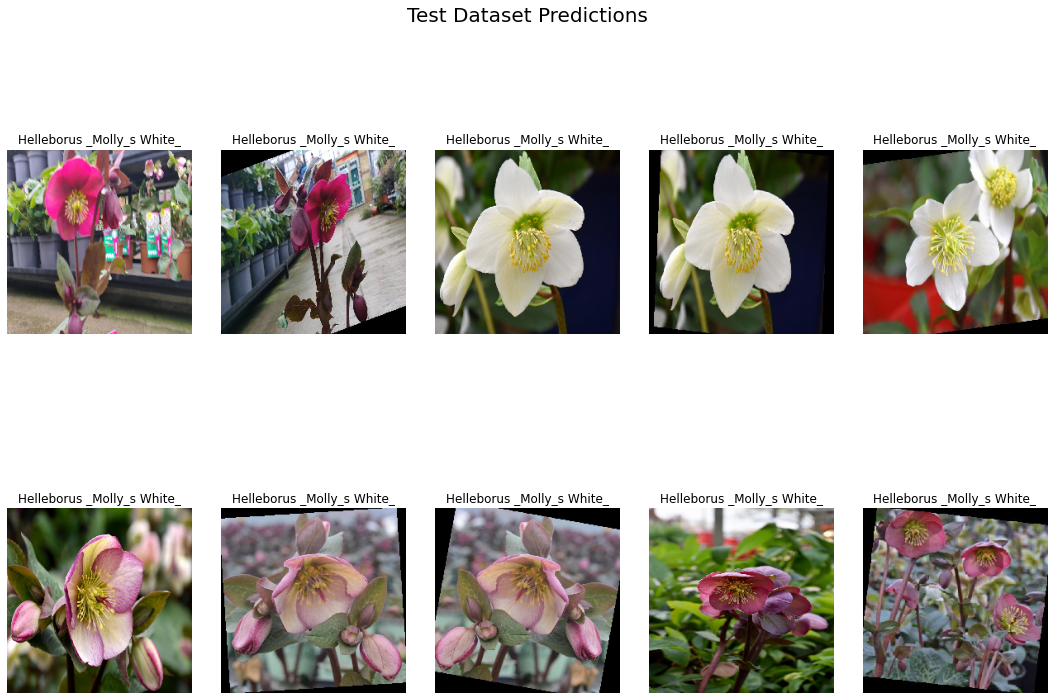

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0
predictions = model_helleborus_EfficientNetB7.predict(validation_generator_helleborus)
for i in range(2):
    for j in range(5):
        predicted_label = labels_helleborus[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(validation_generator_helleborus[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()